# Example BANTS application to mock time series data 

Let's demonstrate how to use the `bants` class on a simple mock example. First we need to import `bants` and other modules to make the mock data and do some plotting...

In [1]:
import sys
path = '/Users/Rob/work/bants/' # Give your path to bants here
sys.path.append(path + 'source/') 
from bants import bants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Now we generate some mock time series data using an n-d Langevin system...

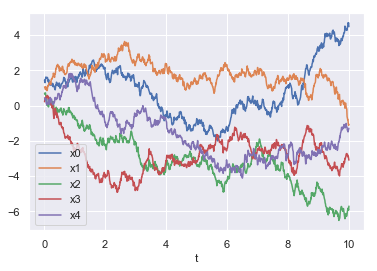

In [2]:
# Evolve the n-d Langevin system
def L_syst_gen(n,runtime,stepsize):    
    # Specify simple drift function with random linear couplings
    def f(x):
        a = np.random.normal(0.0,1.0,size=len(x))
        b = np.random.normal(0.0,1.0,size=len(x))
        return a*x + b*x[np.random.randint(0,len(x),size=len(x))]    
    # Initialise process and run
    t, x = 0.0, np.random.normal(0.0,1.0,size=n)
    out_store = [] 
    while t < runtime:
        t += stepsize
        x += -(stepsize*f(x))+(np.sqrt(stepsize)*np.random.normal(0.0,1.0,size=n))
        out_store.append(np.append(t,x))        
    # Output time series as a pandas dataframe
    out_df = pd.DataFrame(np.asarray(out_store),columns=['t']+['x'+str(ni) for ni in range(0,n)]).set_index('t')
    return out_df
# Choose number of dimensions, total runtime and stepsize
n = 5
runtime = 10.0
stepsize = 0.01
# Run Langevin system and plot output
df = L_syst_gen(n,runtime,stepsize)
df.plot()
plt.show()

The `bants` class works in the same pattern as a `scikit-learn` estimator. We initialise and fit to the dataframe with runs of the Nelder-Mead optimiser...

/Users/Rob/work/bants/source/bants.py:82: RuntimeWarning: invalid value encountered in log
  ((self.Nd/2.0)*np.log(np.pi*nu)) - (0.5*np.log(np.linalg.det(Sigma)))
/Users/Rob/work/bants/source/bants.py:88: RuntimeWarning: invalid value encountered in log
  log_densfunc = np.sum(-((nu+self.Nd)/2.0)*np.log(1.0+(contraction/nu)))


Best fit hyperparameters are: {'nu': 4.003075365602466, 'hsq': array([76.54500716,  8.33902024, 21.76844299, 34.41835134, 21.204243  ]), 'Psi_tril': array([ 0.00888852, -0.00532685,  0.03351064, -0.00373928,  0.01287632,
        0.02732444,  0.00062942, -0.00316322, -0.00288528,  0.00443725,
       -0.00369307,  0.01430307,  0.0148737 , -0.00349357,  0.03215148])}
Best fit log-evidence value is: -14770.126233391264
Converged?: False
Number of function evaluations: 2585


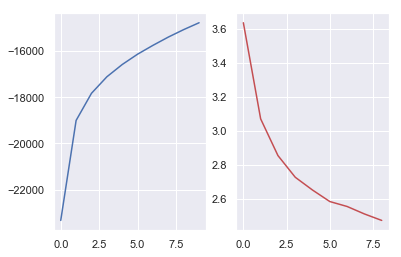

In [3]:
# Initialise class with 'AR-GP' network type (subsequently comment out if iterative runs of the cell are desired)
#bts = bants('AR-GP')
# Set the maximum number of algorithm iterations per fitting run
bts.itmax = 100
nfunc_eval = 0
lnE_vals = []
for i in range(0,10):
    # Apply 'fit' method on the training dataframe to optimise Bayesian network hyperparameters where
    # standardisation of the training data is automatically performed unless the keyword standard=False
    bts.fit(df)
    # Update initial parameter values for next run
    bts.nu_guess = bts.params['nu']
    bts.hsq_guess = bts.params['hsq']
    bts.Psi_tril_guess = bts.params['Psi_tril']
    # Store the log-evidence values from the run and add to the total number of function evaluations
    lnE_vals.append(bts.info['lnE_val'])
    nfunc_eval += bts.info['n_evaluations']
# Display the best fit hyperparameters
print('Best fit hyperparameters are: ' + str(bts.params))
# Display the best fit log-evidence value
print('Best fit log-evidence value is: ' + str(bts.info['lnE_val']))
# Ask if the fitting converged
print('Converged?: ' + str(bts.info['converged']))
# Display the number of function evaluations
print('Number of function evaluations: ' + str(nfunc_eval))
# Plot intermediate values and base-10 logarithmic improvements in the log-evidence after each run
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(lnE_vals,color='b')
ax2.plot(np.log10(np.asarray(lnE_vals[1:])-np.asarray(lnE_vals[:-1])),color='r')
plt.show()

In [5]:
bts.results['sampler'](11.0,100)

ValueError: mean must be 1 dimensional